# Linear Regression

Given a set of $m$ training examples $\left(x^{(i)}, y^{(i)}\right)$ for all $i\in[1,\ldots,m]$, a linear regression model is a supervised learning regression model which expresses $f(x^{(i)})=\hat{y}^{(i)}$ as a linear function of $x^{(i)}$ given parameters $w$ and $b$ as follows:
$$
    \hat{y}^{(i)}=w\cdot x^{(i)}+b
$$

The model is a supervised learning model because the training set contains the "*right*" or expected output value for the target variable for every $x^{(i)}$, and a regression model because the model outputs a continuous value.

Linear regression with one variable is known as a *univariate* linear regression, i.e, $x^{(i)}\in\mathbb{R}$ while *multivariate* linear regression is one wherein $x^{(i)}\in\mathbb{R}^{n}$ for $n>1$ features.

## Cost Function
The goal of the linear regression model is to find optimal parameters $\vec{w}$ and $b$ such that for every training example $\left(x^{(i)}, y^{(i)}\right)$ for $i\in[1,\ldots,m]$
$$
f(x^{(i)})\approx y^{(i)}
$$
Therefore, it helps to provide a precise measure of how *far off* the predicted outputs are from the expected output. This can be formalized as a cost function $J$. A useful cost function for linear regression is the *mean squared error*,
$$
J(w,b)=\frac{1}{2m}\sum_{i=1}^{m}\left(\hat{y}^{(i)} - y^{(i)}\right)^2
$$
The purpose of the $\frac{1}{m}$ is that as gets larger, the value of the cost function gets larger as well,
therefore it helps to build a cost function that does not change significantly just because the size of
the dataset increases. The $2m$ simplifies the calculation of the gradient later on.

Given the cost function, the goal is to find optimal parameters $w^*$ and $b^*$ which minimize $J(w,b)$, i.e,
$$
(w^*,b^*)=\min_{w,b}J(w,b)
$$

## Generating a Synthetic Dataset
The code below generates a synthetic dataset, a set of $m\approx$ `keep * total` training examples $\left(x^{(i)}, y^{(i)}\right)$, where $x^{(i)}\in[x_{low},x_{high}]$ for $i\in[1,\ldots,m]$ such that,
$$
y^{(i)}=w_{true}\cdot x^{(i)}+b_{true}+\epsilon\quad\text{where }\epsilon\sim\mathcal{N}(0, 0.05)
$$

In [1]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

np.random.seed(0)

def generate_linear_dataset(w_true, b_true, x_low, x_high, total, keep):
    x_val  = np.linspace(x_low, x_high, num = total)[np.random.rand(total) > (1 - keep)]
    f_true = lambda x : (w_true * x + b_true)
    y_true = f_true(x_val) + (0.05 * np.random.randn(x_val.shape[0]))
    train  = np.column_stack([x_val, y_true])
    
    return train

In [2]:
w_true = 0.25
b_true = 0.33

train = generate_linear_dataset(w_true, b_true, x_low = -1.0, x_high = 1.0, total = 100, keep = 0.5)
train.shape

(49, 2)

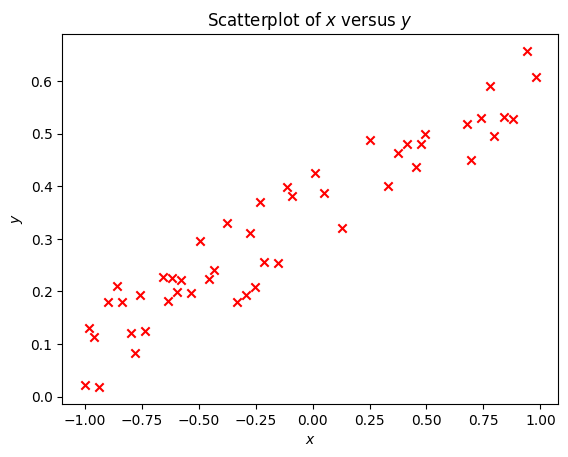

In [3]:
plt.scatter(train[:, 0], train[:, 1], marker = 'x', c = 'red')
plt.title ('Scatterplot of $x$ versus $y$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

## Visualizing the Cost Function

In [4]:
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
Z = np.zeros((x.shape[0], y.shape[0]))

for i, w in enumerate(x):
    for j, b in enumerate(y):
        y_pred  = w * train[:, 0] + b
        y_true  = train[:, 1]
        Z[i, j] = np.mean((y_pred - y_true) ** 2) / 2.0

X, Y = np.meshgrid(x, y)

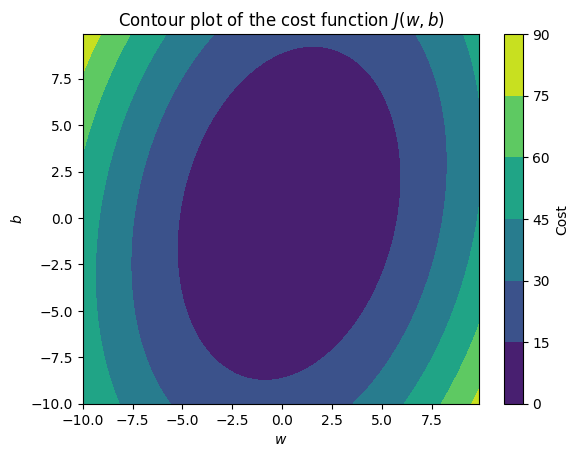

In [5]:
fig, ax = plt.subplots(1, 1)
plt.contourf(X, Y, Z)
plt.xlabel('$w$')
plt.ylabel('$b$')
plt.title ('Contour plot of the cost function $J(w,b)$')
plt.colorbar(label = 'Cost')
plt.show()

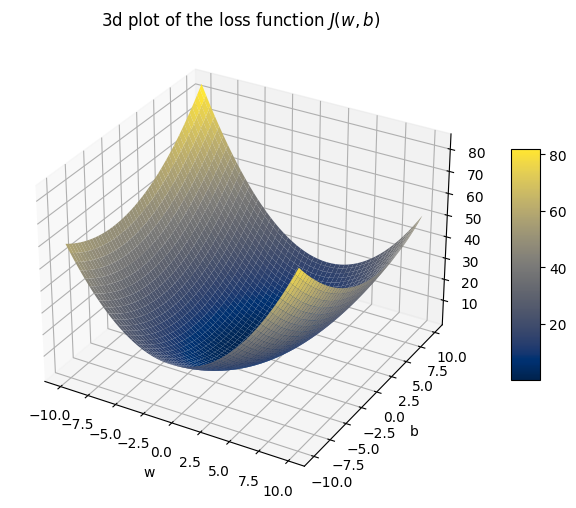

In [6]:
fig = plt.figure(figsize = (10, 6))
ax  = plt.axes(projection = '3d')

surface = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)
fig.colorbar(surface, shrink = 0.5, aspect = 8)
plt.title('3d plot of the loss function $J(w, b)$')
plt.xlabel('w')
plt.ylabel('b')
plt.show()

## Gradient Descent
Gradient descent is an iterative algorithm that allows for a linear regression model -- and many other more complex deep learning models -- to arrive at a minimum of any continuous and differentiable function.

The idea is that given $w$ and $b$ which are initialized in any manner, the algorithm will continuously update these parameters in the steepest direction (negative of the gradient) towards a minimum of the cost function. This iteration is repeated until convergence.

Note that since the mean squared error cost function is *convex*, any local minimum is also the global minimum. This is not necessarily true for other cost functions, leading to multiple local minima depending on the initial starting point.

The parameters $w$ and $b$ on the $k$-th iteration are continuously updated (simultaneously) as follows,
$$
\begin{align*}
    w^{[k+1]}&\leftarrow w^{[k]}-\alpha\frac{\partial J(w^{[k]},b^{[k]})}{\partial w^{[k]}}\\
    b^{[k+1]}&\leftarrow b^{[k]}-\alpha\frac{\partial J(w^{[k]},b^{[k]})}{\partial b^{[k]}}
\end{align*}
$$
where $\alpha$ describes the *learning rate*, essentially a hyperparameter.

### Derivation of the Gradient
Given the cost function $J(w,b)$ which has been previously defined as,
$$
J(w,b)=\frac{1}{2m}\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right)^2
$$
The gradient of the cost function w.r.t the weights $w$ is
$$
\nabla_{\vec{w}}J(w,b)=\begin{bmatrix}
    \frac{\partial J(w,b)}{\partial w_1}, & \dots &, \frac{\partial J(w,b)}{\partial w_j}
\end{bmatrix}^\top
$$
The components of this gradient (where $w_j=w$ in the univariate case and $j\in[1,\ldots,n]$ for the multivariate case) can be calculated as,
$$
\begin{align*}
    \frac{\partial J(w,b)}{\partial w_j}
    &=\frac{\partial}{\partial w_j}\left[\frac{1}{2m}\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right)^2\right]\\
    &=\frac{1}{2m}\cdot\sum_{i=1}^{m}\left[\frac{\partial}{\partial w_j}\left(\hat{y}^{(i)}-y^{(i)}\right)^2\right]\\
    &=\frac{1}{2m}\cdot\sum_{i=1}^{m}\left[2\left(\hat{y}^{(i)}-y^{(i)}\right)\cdot\frac{\partial}{\partial w_j}\left(\vec{w}\cdot \vec{x}^{(i)}+b-y^{(i)}\right)\right]\\
    &=\frac{1}{2m}\sum_{i=1}^{m}\left[2\left(\hat{y}^{(i)}-y^{(i)}\right)\cdot x^{(i)}_j\right]\\
    &=\frac{1}{m}\sum_{i=1}^{m}(\hat{y}^{(i)}-y^{(i)})\cdot x^{(i)}_j
\end{align*}
$$

Likewise, $\frac{\partial J(w,b)}{b}$ can be calculated as 
$$
\frac{\partial J(w,b)}{\partial b}=\frac{1}{m}\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right)
$$

## Implementation

In [7]:
def calc_gradients(w, b, x_train, y_true, y_pred):
    grad_w = np.dot(y_pred - y_true, x_train)
    grad_b = np.mean((y_pred - y_true))
    
    return grad_w, grad_b

learning_rate = 0.1
num_epochs    = 100

w = np.random.randn(1)
b = np.random.randn(1)
L = np.random.randn(num_epochs)

x_train = train[:, 0]
y_train = train[:, 1]

for i in range(num_epochs):
    y_pred   = w * x_train + b
    cost_val = np.mean((y_pred - y_true) ** 2) / 2.0
    grad_w, grad_b = calc_gradients(w, b, x_train, y_train, y_pred)
    grad_w, grad_b
    
    L[i] = cost_val

    w = w - learning_rate * grad_w
    b = b - learning_rate * grad_b    

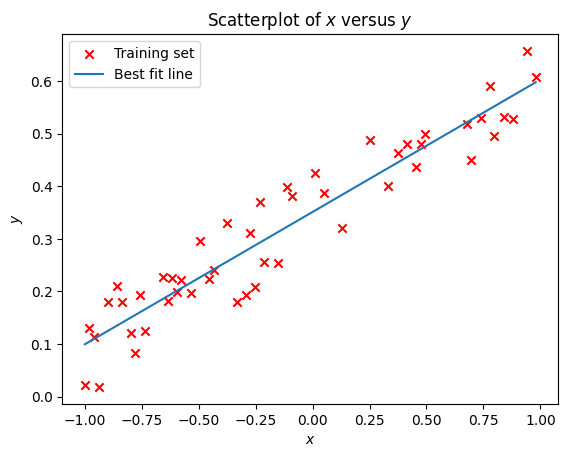

In [8]:
x_pred = np.linspace(x_train.min(), x_train.max())
y_pred = w * x_pred + b

plt.scatter(train[:, 0], train[:, 1], marker = 'x', c = 'red')
plt.plot(x_pred, y_pred)
plt.title ('Scatterplot of $x$ versus $y$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(['Training set', 'Best fit line'])
plt.show()

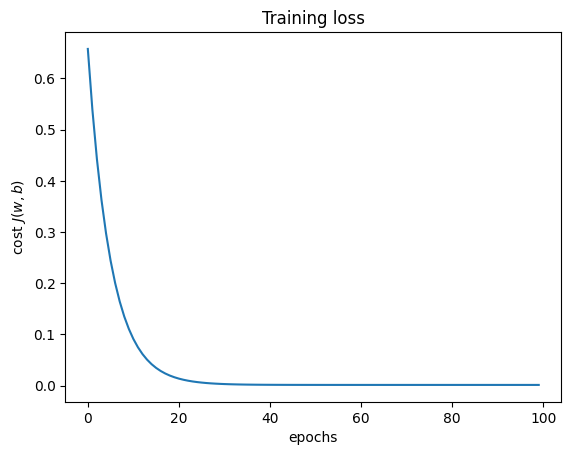

In [9]:
plt.xlabel('epochs')
plt.ylabel('cost $J(w,b)$')
plt.title ('Training loss')
plt.plot(L)
plt.show()

In [10]:
(w, b), (w_true, b_true)

((array([0.25168437]), array([0.35109002])), (0.25, 0.33))